# Gastric-Brain Coupling with Real fMRI Data

This tutorial demonstrates the complete gastric-brain phase coupling
pipeline using real fMRIPrep-preprocessed BOLD data and concurrent EGG.

**What you'll learn:**
- Loading and aligning fMRI-concurrent EGG with BOLD data
- EGG channel selection and narrowband filtering
- BOLD confound regression and phase extraction
- Computing voxelwise PLV maps
- Surrogate statistical testing
- Visualizing volumetric coupling maps with nilearn

**Prerequisites:** ``pip install gastropy[neuro]`` (adds nibabel, nilearn, pooch)

**Data:** ~1.4 GB download on first run (cached for subsequent runs).
Session 0001 from the semi_precision study: 8-channel EGG at 10 Hz,
fMRIPrep BOLD in MNI152NLin2009cAsym space (2 mm), TR = 1.856 s.

**Expected runtime:** ~10 minutes (mostly surrogate computation).

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gastropy as gp
from gastropy.neuro.fmri import (
    align_bold_to_egg,
    apply_volume_cuts,
    bold_voxelwise_phases,
    compute_plv_map,
    compute_surrogate_plv_map,
    create_volume_windows,
    load_bold,
    phase_per_volume,
    regress_confounds,
    to_nifti,
)

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

## 1. Load Data

GastroPy provides ``fetch_fmri_bold`` to download preprocessed BOLD,
brain mask, and confounds from a GitHub Release. The EGG data is
bundled with the package.

In [2]:
# Download BOLD data (~1.4 GB, cached after first run)
fmri_paths = gp.fetch_fmri_bold(session="0001")

# Load bundled EGG data
egg = gp.load_fmri_egg(session="0001")

print("EGG data:")
print(f"  Signal shape: {egg['signal'].shape} (channels x samples)")
print(f"  Sampling rate: {egg['sfreq']} Hz")
print(f"  Scanner triggers: {len(egg['trigger_times'])}")
print(f"  TR: {egg['tr']} s")
print(f"  Duration: {egg['duration_s']:.0f} s ({egg['duration_s'] / 60:.1f} min)")

C:\Users\Micah\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EGG data:
  Signal shape: (8, 7795) (channels x samples)
  Sampling rate: 10.0 Hz
  Scanner triggers: 420
  TR: 1.856 s
  Duration: 780 s (13.0 min)


In [3]:
# Load BOLD NIfTI and brain mask
t0 = time.time()
bold_data = load_bold(fmri_paths["bold"], fmri_paths["mask"])
print(f"BOLD loaded in {time.time() - t0:.1f} s")
print(f"  Volume shape: {bold_data['vol_shape']}")
print(f"  Volumes: {bold_data['n_volumes']}")
print(f"  Brain voxels: {bold_data['bold_2d'].shape[0]:,}")
print(f"  Memory: {bold_data['bold_2d'].nbytes / 1e9:.2f} GB")

# Load confounds
confounds = pd.read_csv(fmri_paths["confounds"], sep="\t")
print(f"\nConfounds: {confounds.shape[0]} rows x {confounds.shape[1]} columns")

BOLD loaded in 8.1 s
  Volume shape: (85, 106, 90)
  Volumes: 480
  Brain voxels: 356,104
  Memory: 0.68 GB

Confounds: 480 rows x 563 columns


## 2. Align BOLD Volumes to EGG Triggers

The BOLD file from fMRIPrep may contain more volumes than EGG triggers
(e.g., dummy scans at the start/end). We align by keeping only the
BOLD volumes that correspond to EGG scanner triggers.

In [4]:
n_triggers = len(egg["trigger_times"])
print(f"BOLD volumes: {bold_data['n_volumes']}")
print(f"EGG triggers: {n_triggers}")
print(f"Discarding {bold_data['n_volumes'] - n_triggers} extra BOLD volumes")

bold_2d, confounds_aligned = align_bold_to_egg(bold_data["bold_2d"], n_triggers, confounds)
print(f"\nAligned BOLD: {bold_2d.shape}")
print(f"Aligned confounds: {confounds_aligned.shape}")

BOLD volumes: 480
EGG triggers: 420
Discarding 60 extra BOLD volumes

Aligned BOLD: (356104, 420)
Aligned confounds: (420, 563)


## 3. EGG Processing: Channel Selection and Filtering

We identify the best EGG channel (strongest gastric rhythm) and its
individual peak frequency, then narrowband filter the EGG at that
frequency.

In [5]:
sfreq = egg["sfreq"]
ch_names = list(egg["ch_names"])

# Select best channel and peak frequency
best_idx, peak_freq, freqs, psd = gp.select_best_channel(egg["signal"], sfreq)
print(f"Best channel: {ch_names[best_idx]} (index {best_idx})")
print(f"Peak frequency: {peak_freq:.4f} Hz ({peak_freq * 60:.2f} cpm)")

# Compute all-channel PSD for plotting
all_psd = np.column_stack([gp.psd_welch(egg["signal"][i], sfreq)[1] for i in range(egg["signal"].shape[0])]).T

Best channel: EGG8 (index 7)
Peak frequency: 0.0400 Hz (2.40 cpm)


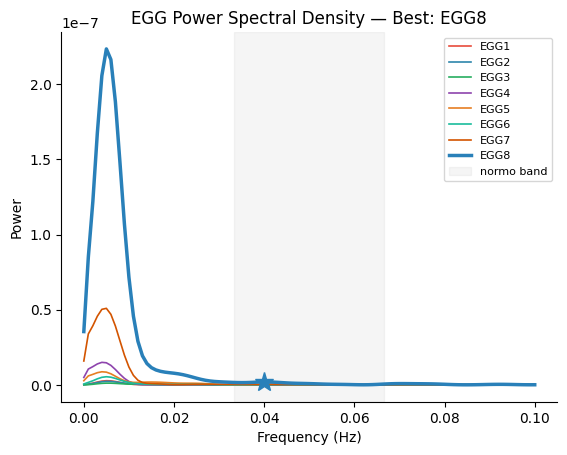

In [6]:
fig, ax = gp.plot_psd(freqs, all_psd, best_idx=best_idx, peak_freq=peak_freq, ch_names=ch_names)
ax.set_title(f"EGG Power Spectral Density \u2014 Best: {ch_names[best_idx]}")
plt.show()

In [7]:
# Narrowband filter at individual peak frequency
hwhm = 0.015  # Hz (half-width at half-maximum)
low_hz = peak_freq - hwhm
high_hz = peak_freq + hwhm
print(f"Filter band: {low_hz:.4f} - {high_hz:.4f} Hz")

filtered, filt_info = gp.apply_bandpass(egg["signal"][best_idx], sfreq, low_hz=low_hz, high_hz=high_hz)
phase, analytic = gp.instantaneous_phase(filtered)
print(f"Filter taps: {filt_info.get('fir_numtaps', 'N/A')}")

Filter band: 0.0250 - 0.0550 Hz


Filter taps: 501


## 4. Per-Volume EGG Phase

Map the continuous EGG phase (10 Hz) to one phase value per fMRI volume,
then trim 21 transient volumes from each edge (standard practice to
remove filter ringing artifacts).

In [8]:
windows = create_volume_windows(egg["trigger_times"], egg["tr"], n_triggers)
egg_vol_phase = phase_per_volume(analytic, windows)

begin_cut, end_cut = 21, 21
egg_phase = apply_volume_cuts(egg_vol_phase, begin_cut, end_cut)

print(f"Per-volume phases: {len(egg_vol_phase)}")
print(f"After trimming ({begin_cut} + {end_cut}): {len(egg_phase)}")

Per-volume phases: 420
After trimming (21 + 21): 378


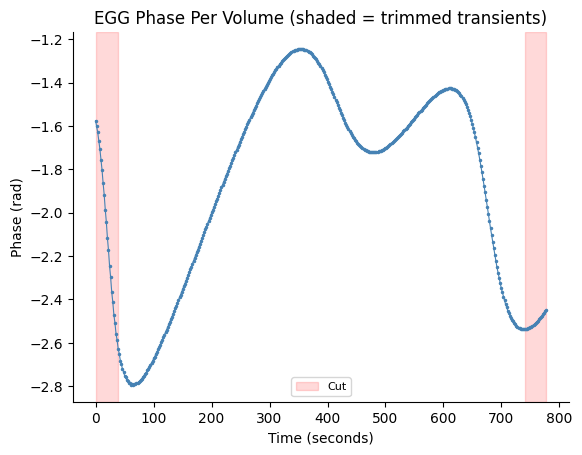

In [9]:
fig, ax = gp.plot_volume_phase(egg_vol_phase, tr=egg["tr"], cut_start=begin_cut, cut_end=end_cut)
ax.set_title("EGG Phase Per Volume (shaded = trimmed transients)")
plt.show()

## 5. BOLD Processing

### 5a. Confound Regression

Remove motion and noise confounds from BOLD data using GLM regression.
Default regressors: 6 motion parameters + 6 aCompCor components
(12 total).

In [10]:
t0 = time.time()
residuals = regress_confounds(bold_2d, confounds_aligned)
elapsed = time.time() - t0
print(f"Confound regression: {elapsed:.1f} s ({residuals.shape[0]:,} voxels)")

Confound regression: 5.1 s (356,104 voxels)


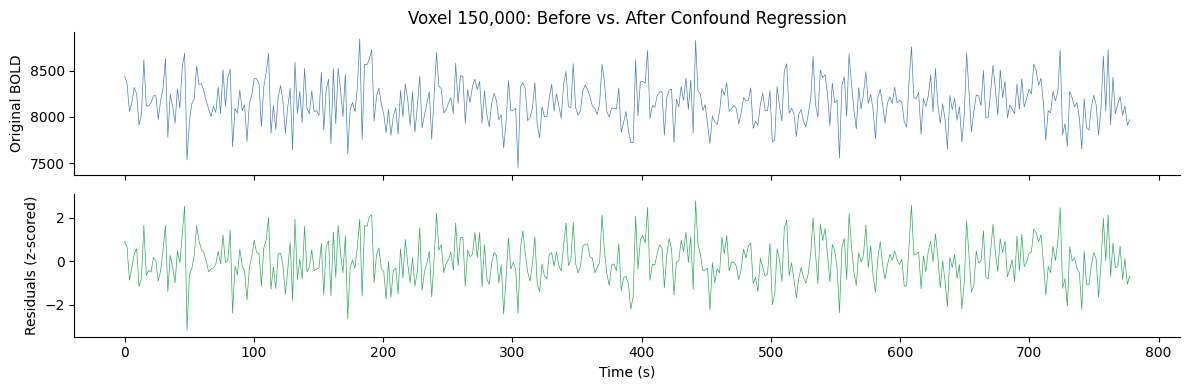

In [11]:
# Show effect of confound regression on an example voxel
voxel_idx = 150000
fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

t_vol = np.arange(n_triggers) * egg["tr"]
axes[0].plot(t_vol, bold_2d[voxel_idx], linewidth=0.5, color="steelblue")
axes[0].set_ylabel("Original BOLD")
axes[0].set_title(f"Voxel {voxel_idx:,}: Before vs. After Confound Regression")

axes[1].plot(t_vol, residuals[voxel_idx], linewidth=0.5, color="#27AE60")
axes[1].set_ylabel("Residuals (z-scored)")
axes[1].set_xlabel("Time (s)")

for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

### 5b. BOLD Phase Extraction

Bandpass filter each voxel at the same gastric frequency as the EGG,
then extract instantaneous phase via Hilbert transform.

We use an IIR (Butterworth) filter because BOLD time series are too
short (~420 volumes) for the FIR filter that works at EGG sampling
rates. The vectorized IIR path processes all ~350K voxels at once.

In [12]:
t0 = time.time()
bold_phases = bold_voxelwise_phases(
    residuals,
    peak_freq,
    sfreq=1 / egg["tr"],
    begin_cut=begin_cut,
    end_cut=end_cut,
)
elapsed = time.time() - t0
print(f"BOLD phase extraction: {elapsed:.1f} s ({residuals.shape[0]:,} voxels)")
print(f"BOLD phases shape: {bold_phases.shape}")
print(f"EGG phase length:  {len(egg_phase)} (should match)")

BOLD phase extraction: 6.9 s (356,104 voxels)
BOLD phases shape: (356104, 378)
EGG phase length:  378 (should match)


## 6. Compute PLV Map

Phase-locking value (PLV) between EGG phase and each BOLD voxel's
phase. Values range from 0 (no coupling) to 1 (perfect phase locking).

In [13]:
plv_3d = compute_plv_map(
    egg_phase,
    bold_phases,
    vol_shape=bold_data["vol_shape"],
    mask_indices=bold_data["mask"],
)

plv_flat = plv_3d[bold_data["mask"]]

print(f"PLV volume shape: {plv_3d.shape}")
print("PLV statistics (brain voxels only):")
print(f"  Mean:   {plv_flat.mean():.4f}")
print(f"  Median: {np.median(plv_flat):.4f}")
print(f"  Max:    {plv_flat.max():.4f}")
print(f"  Std:    {plv_flat.std():.4f}")

PLV volume shape: (85, 106, 90)
PLV statistics (brain voxels only):
  Mean:   0.0250
  Median: 0.0233
  Max:    0.1071
  Std:    0.0134


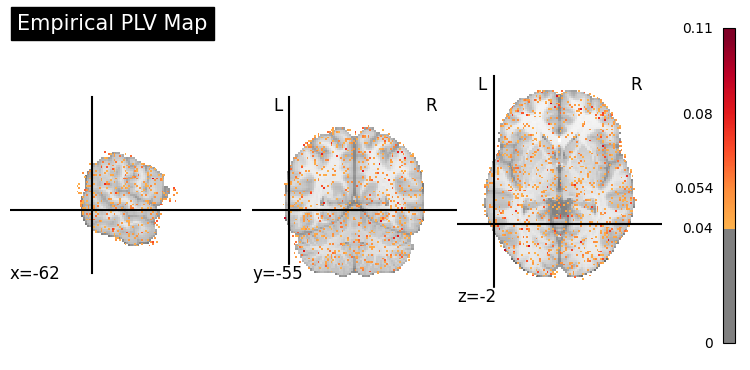

In [14]:
plv_img = to_nifti(plv_3d, bold_data["affine"])

# Stat map overlay on MNI template
display = gp.plot_coupling_map(plv_img, threshold=0.04, title="Empirical PLV Map")
plt.show()

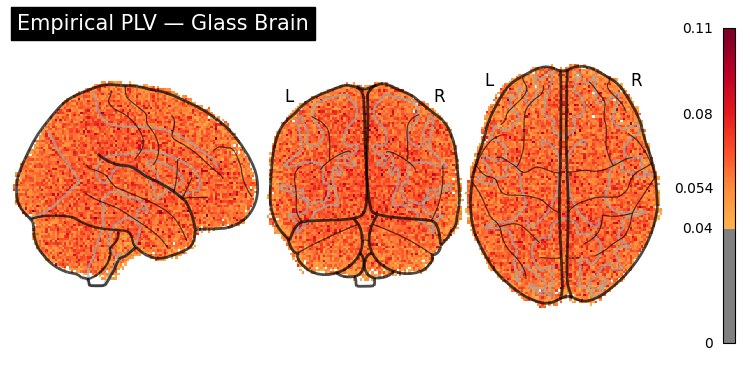

In [15]:
# Glass brain (transparent overview)
display = gp.plot_glass_brain(plv_img, threshold=0.04, title="Empirical PLV \u2014 Glass Brain")
plt.show()

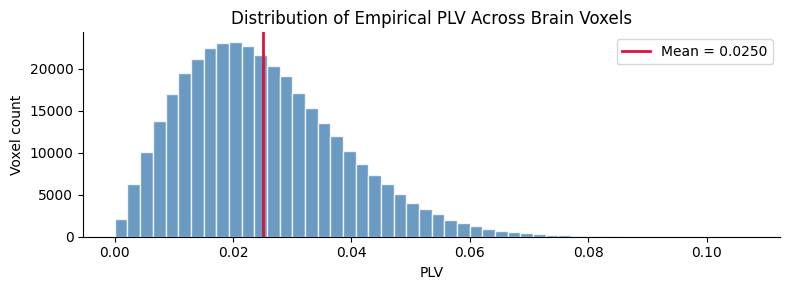

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(plv_flat, bins=50, color="steelblue", edgecolor="white", alpha=0.8)
ax.axvline(plv_flat.mean(), color="crimson", linewidth=2, label=f"Mean = {plv_flat.mean():.4f}")
ax.set_xlabel("PLV")
ax.set_ylabel("Voxel count")
ax.set_title("Distribution of Empirical PLV Across Brain Voxels")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

## 7. Surrogate Statistical Testing

Observed PLV may be non-zero by chance due to autocorrelation. We test
significance using the **circular time-shift** method: shift the EGG
phase by random offsets and recompute PLV to build a null distribution.

We use 50 surrogates here for speed. For publication, use 200+.

In [17]:
t0 = time.time()
surr_3d = compute_surrogate_plv_map(
    egg_phase,
    bold_phases,
    vol_shape=bold_data["vol_shape"],
    mask_indices=bold_data["mask"],
    n_surrogates=50,
    seed=42,
)
elapsed = time.time() - t0
surr_flat = surr_3d[bold_data["mask"]]

print(f"Surrogate PLV: {elapsed:.1f} s (50 circular shifts)")
print("Surrogate PLV (brain voxels):")
print(f"  Mean: {surr_flat.mean():.4f}")
print(f"  Max:  {surr_flat.max():.4f}")

Surrogate PLV: 189.0 s (50 circular shifts)
Surrogate PLV (brain voxels):
  Mean: 0.0251
  Max:  0.1012


In [18]:
# Z-score: empirical - surrogate (positive = true coupling)
z_3d = np.zeros_like(plv_3d)
z_3d[bold_data["mask"]] = gp.coupling_zscore(plv_flat, surr_flat)
z_flat = z_3d[bold_data["mask"]]

print("Coupling z-score (brain voxels):")
print(f"  Mean:  {z_flat.mean():.4f}")
print(f"  Max:   {z_flat.max():.4f}")
print(f"  >0.01: {(z_flat > 0.01).sum():,} voxels ({(z_flat > 0.01).mean():.1%})")

Coupling z-score (brain voxels):
  Mean:  -0.0001
  Max:   0.0585
  >0.01: 62,855 voxels (17.7%)


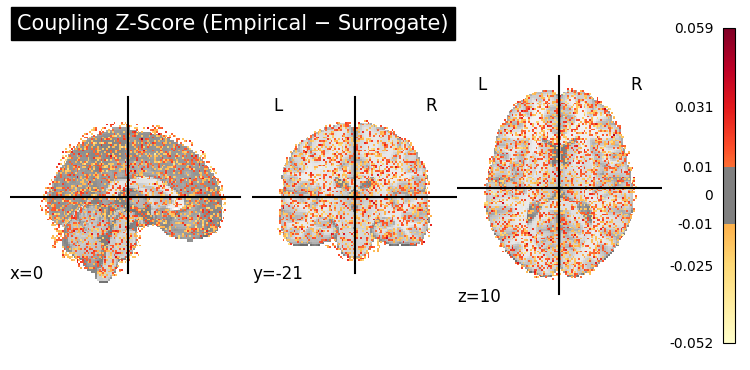

In [19]:
z_img = to_nifti(z_3d, bold_data["affine"])

display = gp.plot_coupling_map(
    z_img,
    threshold=0.01,
    title="Coupling Z-Score (Empirical \u2212 Surrogate)",
    cmap="YlOrRd",
)
plt.show()

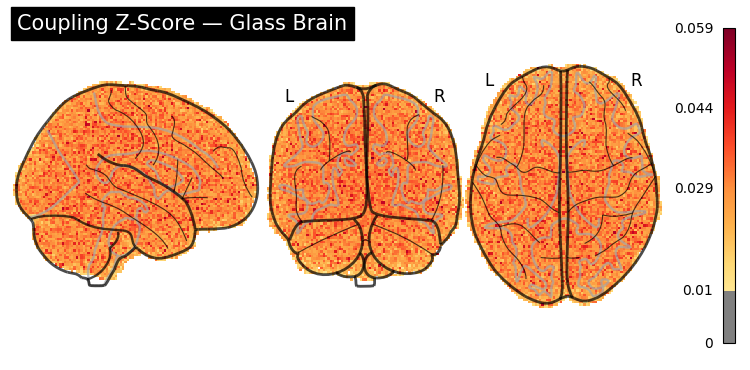

In [20]:
display = gp.plot_glass_brain(
    z_img,
    threshold=0.01,
    title="Coupling Z-Score \u2014 Glass Brain",
)
plt.show()

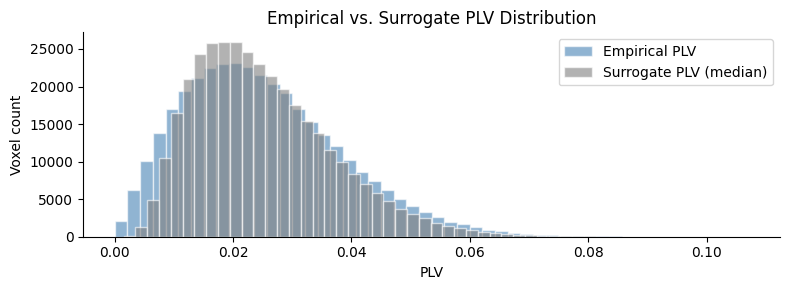

In [21]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(plv_flat, bins=50, alpha=0.6, color="steelblue", edgecolor="white", label="Empirical PLV")
ax.hist(surr_flat, bins=50, alpha=0.6, color="grey", edgecolor="white", label="Surrogate PLV (median)")
ax.set_xlabel("PLV")
ax.set_ylabel("Voxel count")
ax.set_title("Empirical vs. Surrogate PLV Distribution")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

## 8. Summary

This tutorial demonstrated the complete Rebollo et al. gastric-brain
coupling pipeline on real fMRIPrep data:

| Step | Function | Time |
|------|----------|------|
| Load BOLD + mask | ``load_bold`` | ~8 s |
| Align volumes | ``align_bold_to_egg`` | instant |
| EGG channel selection | ``select_best_channel`` | instant |
| EGG bandpass + phase | ``apply_bandpass`` + ``instantaneous_phase`` | instant |
| Per-volume phase | ``phase_per_volume`` + ``apply_volume_cuts`` | instant |
| Confound regression | ``regress_confounds`` | ~5 s |
| BOLD phase extraction | ``bold_voxelwise_phases`` (IIR, vectorized) | ~7 s |
| PLV map | ``compute_plv_map`` | ~1 s |
| Surrogate testing | ``compute_surrogate_plv_map`` (50 shifts) | ~3 min |
| Visualization | ``plot_coupling_map`` / ``plot_glass_brain`` | instant |

**Key parameters:**
- EGG peak frequency: individual (data-driven)
- Filter bandwidth: peak ± 0.015 Hz (HWHM)
- Volume trimming: 21 from each edge
- Confounds: 6 motion + 6 aCompCor (12 regressors)
- BOLD filter: IIR Butterworth order 4 (vectorized)

**For publication-quality results:**
- Use ``n_surrogates=200`` (or more)
- Consider using the full surrogate distribution (``stat="all"``)
  to compute permutation p-values and FDR correction